In [4]:
!wget https://raw.githubusercontent.com/spqb/adabmDCApy/main/example_data/RF00379.fasta

--2025-02-13 10:29:30--  https://raw.githubusercontent.com/spqb/adabmDCApy/main/example_data/RF00379.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 650123 (635K) [text/plain]
Saving to: ‘RF00379.fasta’

RF00379.fasta       100%[===================>] 634,89K  --.-KB/s    in 0,04s   

2025-02-13 10:29:31 (17,1 MB/s) - ‘RF00379.fasta’ saved [650123/650123]



In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Import some useful functions from adabmDCA
from adabmDCA.fasta import get_tokens
from adabmDCA.utils import get_device, get_dtype
from adabmDCA.stats import get_freq_single_point, get_freq_two_points, get_correlation_two_points
from adabmDCA.dataset import DatasetDCA
from arDCA import arDCA

In [2]:
# Set the device
device = get_device("cuda")
dtype = get_dtype("float32")

Running on NVIDIA RTX A5000


In [3]:
output_folder = "./output"
folder = Path(output_folder)
folder.mkdir(parents=True, exist_ok=True)

# Label for the ouput files
label = "arDCA"

# Paths for the output files
path_params = f"{label}_params.pth"

In [4]:
# Select the alphabet correspondig to RNA sequences
data_type = "rna"
tokens = get_tokens(data_type)
path_data = "./RF00379.fasta"
dataset = DatasetDCA(
    path_data=path_data,
    alphabet=data_type,
    device=device,
    dtype=dtype,
)
M, L, q = len(dataset), dataset.get_num_residues(), dataset.get_num_states()

Automatically computing the sequence weights...
Multi-sequence alignment imported: M = 3827, L = 136, q = 5, M_eff = 1446.


In [5]:
msa_oh = nn.functional.one_hot(dataset.data.to(torch.long), num_classes=q).to(dtype=dtype)
# Set the random seed
torch.manual_seed(0)

In [6]:
pseudocount = 0.01
fi_target = get_freq_single_point(data=msa_oh, weights=dataset.weights, pseudo_count=pseudocount)
fij_target = get_freq_two_points(data=msa_oh, weights=dataset.weights, pseudo_count=pseudocount)

In [7]:
# Initialize the model
model = arDCA(L=L, q=q).to(device=device, dtype=dtype)

In [ ]:
# Hyperparameters
lr = 0.005
max_epochs = 1000
epsconv = 1e-2
# These are not the default regularization parameters. They have been tuned for this specific example.
reg_h = 1e-4
reg_J = 1e-2

In [9]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
model.fit(
    X=msa_oh,
    weights=dataset.weights,
    pseudo_count=pseudocount,
    optimizer=optimizer,
    max_epochs=max_epochs,
    use_entropic_order=True,
    reg_h=reg_h,
    reg_J=reg_J,
)

In [11]:
from adabmDCA.pca import Pca
from adabmDCA.plot import plot_PCA
from adabmDCA.utils import resample_sequences

In [ ]:
pca = Pca()
num_samples = 10000
resampled_sequences = resample_sequences(msa_oh, dataset.weights, nextract=num_samples)
data_proj = pca.fit_transform(resampled_sequences.view(num_samples, -1), num_directions=3)
data_proj = data_proj.cpu().numpy()

In [ ]:
samples = model.sample(n_samples=num_samples)
samples_proj = pca.transform(samples.view(num_samples, -1))
samples_proj = samples_proj.cpu().numpy()

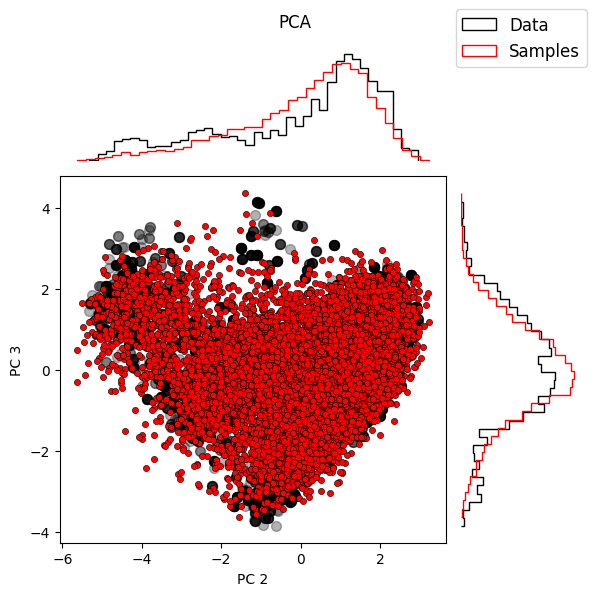

In [15]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    data2=samples_proj,
    pc1=1,
    pc2=2,
    labels=["Data", "Samples"],
    title="PCA",
)
fig.tight_layout()

In [16]:
pi = get_freq_single_point(samples)
pij = get_freq_two_points(samples)
pearson, slope = get_correlation_two_points(fi=fi_target, fij=fij_target, pi=pi, pij=pij)
print(f"Pearson: {pearson:.2f}, slope: {slope:.2f}")

Pearson: 0.96, slope: 0.66
